# Where to open a coffee shop in Manhattan

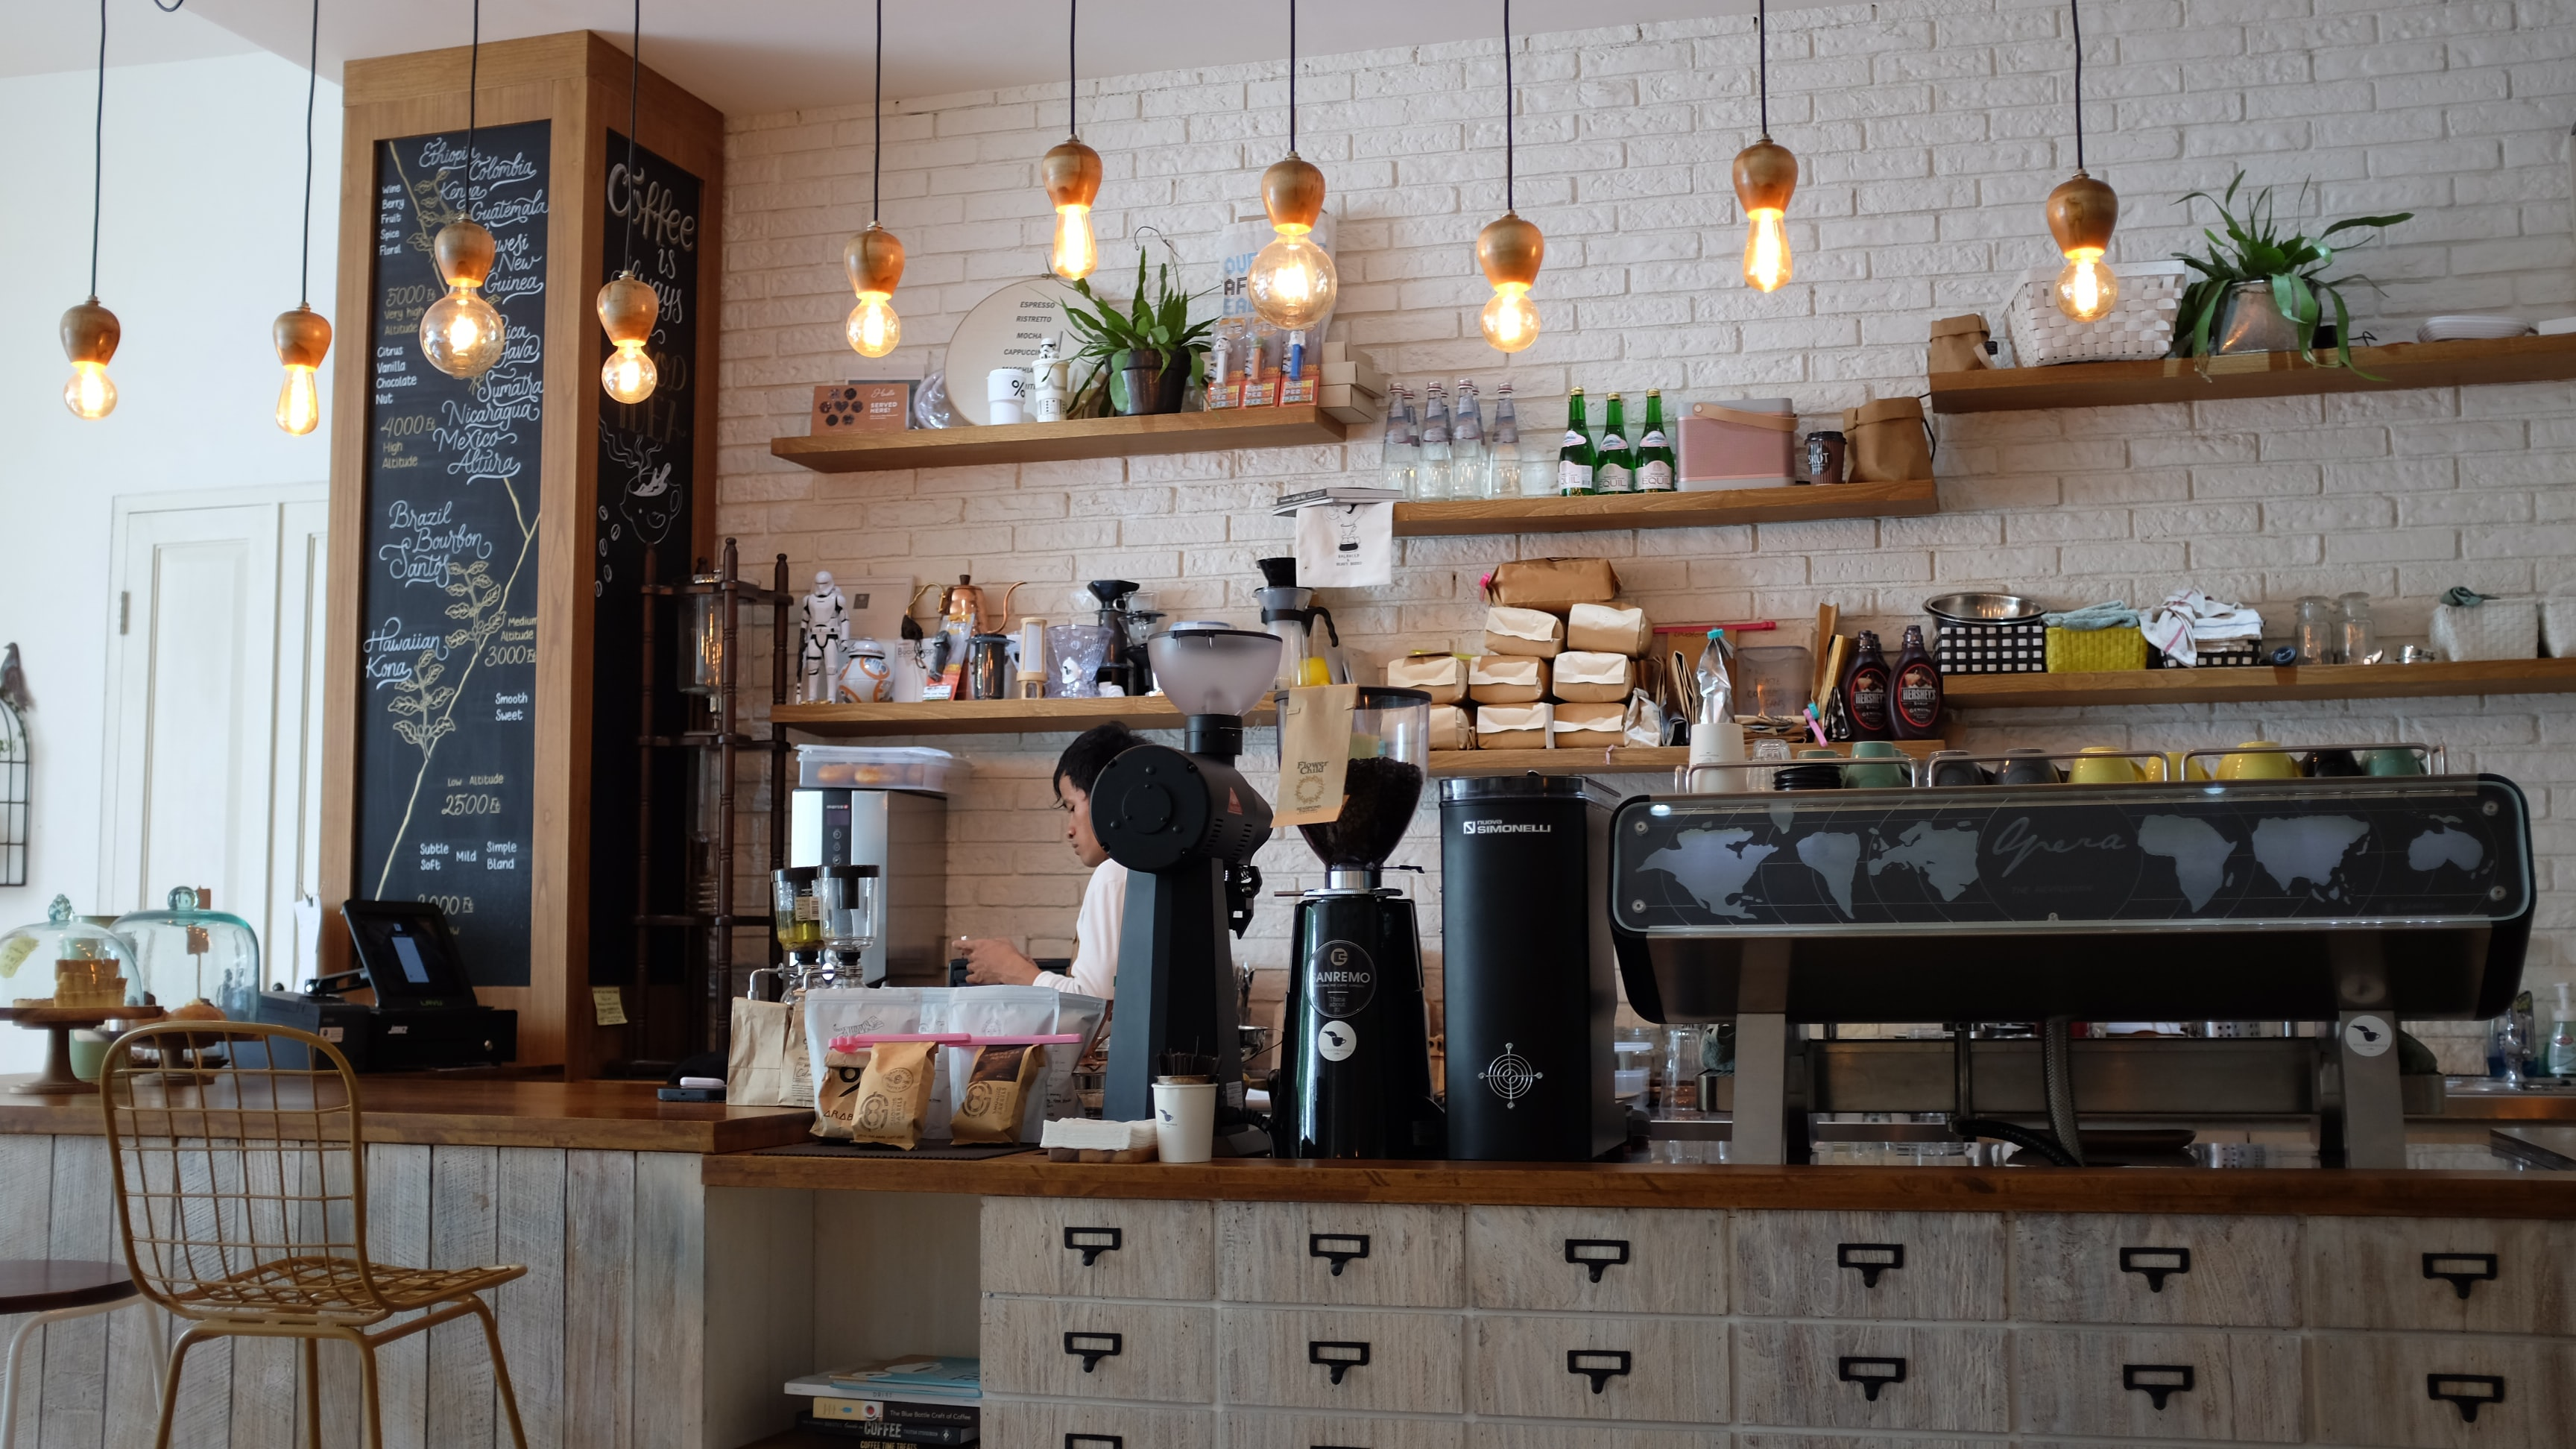

## Table of contents
* [1. Introduction: Business Problem](#introduction)
* [2. Data](#data)
* [3. Analysis](#Analysis)
* [4. Result](#result)
* [5. Discussion](#discussion)
* [6. Conclusion](#conclusion)


## 1. Introduction: Business Problem <a name="introduction"></a>

There are 137 major coffee shops in the 22.7 square miles of Manhattan. That means there are approximately 5 major coffee shops every square mile. In this project, we will try to find an optimal location to open a new coffee shop. Specifically, this report will be targeted to stakeholders interested in opening an **coffee shop** in **Manhattan**, NY. Since there are lots of coffee shops in Manhattan we will try to detect locations that are **not already crowded** by coffee shops. We are also particularly interested in **areas with no Starbucks coffee** in vicinity to make sure our market entry strategy goes smoothlier. We would also prefer locations **as close to city center as possible**.

By using data analytics, we will find a few most promissing neighborhoods based on this criteria. Each area will then be evaluated clearly so that best possible final location can be chosen.

Before we get the data and start exploring it, let's download all the dependencies that we will need.

## 2. Data <a name="data"></a> 

Factors that will influence our decission are:
* number of existing coffee shops in the neighborhood 
* number of and distance to any coffee shops in the neighborhood
* number of and distance to Starbucks coffee in the neighborhood
* distance of neighborhood from city center

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:
* centers of candidate areas will be generated algorithmically and approximate addresses of centers of those areas will be obtained using **Google Maps API reverse geocoding**
* number of coffee shops and location in every neighborhood will be obtained using **Foursquare API**
* coordinate of Manhattan center will be obtained using **Google Maps API geocoding** of well known Manhattan location

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

<a id='item1'></a>

## 3. Analysis <a name="Analysis"></a>

Neighborhood has a total of 5 boroughs and 306 neighborhoods. In order to segement the neighborhoods and explore them, we will essentially need a dataset that contains the 5 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. Here is the link to the dataset: https://geo.nyu.edu/catalog/nyu_2451_34572

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


#### Load and explore the data

Next, let's load the data.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [7]:
neighborhoods.shape

(306, 4)

In [52]:
neighborhoods.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585
5,Bronx,Kingsbridge,40.881687,-73.902818
6,Manhattan,Marble Hill,40.876551,-73.910660
7,Bronx,Woodlawn,40.898273,-73.867315
8,Bronx,Norwood,40.877224,-73.879391
9,Bronx,Williamsbridge,40.881039,-73.857446


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [9]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Manhattan.

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.

In [10]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


#### Create a map of Manhattan with neighborhoods superimposed on top.

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.

However, for illustration purposes, let's simplify the above map and segment and cluster only the neighborhoods in Manhattan. So let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [11]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head(10)

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688
5,Manhattan,Manhattanville,40.816934,-73.957385
6,Manhattan,Central Harlem,40.815976,-73.943211
7,Manhattan,East Harlem,40.792249,-73.944182
8,Manhattan,Upper East Side,40.775639,-73.960508
9,Manhattan,Yorkville,40.775930,-73.947118


Let's create a map of Manhattan with neighborhoods superimposed on top.

In [12]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [13]:
CLIENT_ID = 'GNXWGWSNCGH1JOWOF5JTP5AO1XNL1SKHZ155YCZXGTXQIGBW' # your Foursquare ID
CLIENT_SECRET = 'KI5YVZYISF10NPQ5RFY3ZQCU2GWN1JFZRTTYPEQ0ICCYVXLE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Your credentails:
CLIENT_ID: 2T5YYXM0C5GHFZHW1WBXWMWROLQEV5LAYJVR4WLWISXXA4PB
CLIENT_SECRET:Y45CS101NIBA12IUQJGOBBUKOVZWJY2XEARFYHZ22CLST3R2


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [14]:
manhattan_data.loc[0, 'Neighborhood']

'Marble Hill'

Get the neighborhood's latitude and longitude values.

In [15]:
neighborhood_latitude = manhattan_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = manhattan_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = manhattan_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Marble Hill are 40.87655077879964, -73.91065965862981.


#### Now, let's get the top 100 venues that are in Marble Hill within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [16]:
# type your answer here

LIMIT = 1000
radius = 500

#use explore to find top 100 venues
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=2T5YYXM0C5GHFZHW1WBXWMWROLQEV5LAYJVR4WLWISXXA4PB&client_secret=Y45CS101NIBA12IUQJGOBBUKOVZWJY2XEARFYHZ22CLST3R2&v=20180605&ll=40.87655077879964,-73.91065965862981&radius=500&limit=1000'

Send the GET request and examine the resutls

In [17]:
results = requests.get(url).json()

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [18]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [19]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


,name,categories,lat,lng
0,Arturo's,Pizza Place,40.874412,-73.910271
1,Bikram Yoga,Yoga Studio,40.876844,-73.906204
2,Tibbett Diner,Diner,40.880404,-73.908937
3,Starbucks,Coffee Shop,40.877531,-73.905582
4,Dunkin',Donut Shop,40.877136,-73.906666


And how many venues were returned by Foursquare?

In [20]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

26 venues were returned by Foursquare.


<a id='item2'></a>

## 3.1 Explore Neighborhoods in Manhattan

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *manhattan_venues*.

In [22]:
# type your answer here

manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )



Marble Hill
Chinatown
Washington Heights
Inwood
Hamilton Heights
Manhattanville
Central Harlem
East Harlem
Upper East Side
Yorkville
Lenox Hill
Roosevelt Island
Upper West Side
Lincoln Square
Clinton
Midtown
Murray Hill
Chelsea
Greenwich Village
East Village
Lower East Side
Tribeca
Little Italy
Soho
West Village
Manhattan Valley
Morningside Heights
Gramercy
Battery Park City
Financial District
Carnegie Hill
Noho
Civic Center
Midtown South
Sutton Place
Turtle Bay
Tudor City
Stuyvesant Town
Flatiron
Hudson Yards


Double-click __here__ for the solution.
<!-- The correct answer is:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )
--> 

#### Let's check the size of the resulting dataframe

In [23]:
print(manhattan_venues.shape)
manhattan_venues.head(10)

(3093, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop
5,Marble Hill,40.876551,-73.91066,Rite Aid,40.875467,-73.908906,Pharmacy
6,Marble Hill,40.876551,-73.91066,TCR The Club of Riverdale,40.878628,-73.914568,Tennis Stadium
7,Marble Hill,40.876551,-73.91066,Land & Sea Restaurant,40.877885,-73.905873,Seafood Restaurant
8,Marble Hill,40.876551,-73.91066,Starbucks,40.873755,-73.908613,Coffee Shop
9,Marble Hill,40.876551,-73.91066,Astral Fitness & Wellness Center,40.876705,-73.906372,Gym


##### Find a list of coffee shops in Manhattan

In [24]:
manhattan_coffee = manhattan_venues[manhattan_venues['Venue Category']=='Coffee Shop']
print(manhattan_coffee.shape)
manhattan_coffee.head(10)

(139, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
8,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
73,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop
93,Chinatown,40.715618,-73.994279,Cafe Grumpy,40.715069,-73.989952,Coffee Shop
110,Chinatown,40.715618,-73.994279,Oliver Coffee,40.712986,-73.998106,Coffee Shop
128,Washington Heights,40.851903,-73.936900,Forever Coffee Bar,40.850433,-73.936607,Coffee Shop
161,Washington Heights,40.851903,-73.936900,Starbucks,40.850961,-73.938330,Coffee Shop
241,Inwood,40.867684,-73.921210,Kuro Kirin,40.866223,-73.925691,Coffee Shop
286,Hamilton Heights,40.823604,-73.949688,Monkey Cup,40.825694,-73.947234,Coffee Shop
292,Hamilton Heights,40.823604,-73.949688,Matto Espresso (Espresso Matto),40.824958,-73.951759,Coffee Shop


##### Create a map of coffee shops in Manhattan

In [25]:
# create map of Manhattan using latitude and longitude values
manhattan_coffee_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, label in zip(manhattan_coffee['Venue Latitude'], manhattan_coffee['Venue Longitude'], manhattan_coffee['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_coffee_map)  
    
manhattan_coffee_map

Find a list of Starbucks coffee in Manhattan

In [26]:
manhattan_starbucks = manhattan_venues[manhattan_venues['Venue']=='Starbucks']
print(manhattan_starbucks.shape)
manhattan_starbucks.head(10)

(16, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
3,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop
8,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop
161,Washington Heights,40.851903,-73.936900,Starbucks,40.850961,-73.938330,Coffee Shop
354,Manhattanville,40.816934,-73.957385,Starbucks,40.815074,-73.958930,Coffee Shop
644,Yorkville,40.775930,-73.947118,Starbucks,40.772356,-73.949984,Coffee Shop
758,Roosevelt Island,40.762160,-73.949168,Starbucks,40.759360,-73.953153,Coffee Shop
1944,Manhattan Valley,40.797307,-73.964286,Starbucks,40.795369,-73.965589,Coffee Shop
1971,Manhattan Valley,40.797307,-73.964286,Starbucks,40.798880,-73.968370,Coffee Shop
2098,Gramercy,40.737210,-73.981376,Starbucks,40.733230,-73.980820,Coffee Shop
2238,Financial District,40.707107,-74.010665,Starbucks,40.705162,-74.011300,Coffee Shop


Add Starbucks coffee location to Manhattan coffee map

In [27]:
# add markers to map
for lat, lng, label in zip(manhattan_starbucks['Venue Latitude'], manhattan_starbucks['Venue Longitude'], manhattan_starbucks['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='darkgreen',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(manhattan_coffee_map)  
    
manhattan_coffee_map

Add Coffee and Starbucks into into the dataframe

In [28]:
#Copying the movie dataframe into a new one since we won't need to use the genre information in our first case.

manhattan_coffee['Coffee'] = np.where(manhattan_coffee['Venue Category']=='Coffee Shop', 1, 0)
manhattan_coffee['Starbucks'] = np.where(manhattan_coffee['Venue']=='Starbucks', 1, 0)
manhattan_coffee.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Coffee,Starbucks
3,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop,1,1
8,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop,1,1
73,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop,1,0
93,Chinatown,40.715618,-73.994279,Cafe Grumpy,40.715069,-73.989952,Coffee Shop,1,0
110,Chinatown,40.715618,-73.994279,Oliver Coffee,40.712986,-73.998106,Coffee Shop,1,0


In [29]:
manhattan_coffee.shape

(139, 9)

#### Neighborhood coordinate

In [30]:
neighborhood_coord = manhattan_coffee[['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']].groupby('Neighborhood').mean()
neighborhood_coord.reset_index()
neighborhood_coord.dtypes

Neighborhood Latitude     float64
Neighborhood Longitude    float64
dtype: object

#### Neighborhood distance to Times Square

In [31]:
address = 'Times Square, NY'

geolocatorTQ = Nominatim(user_agent="ny_explorer")
locationTQ = geolocatorTQ.geocode(address)
latitudeTQ = locationTQ.latitude
longitudeTQ = locationTQ.longitude
print('The geograpical coordinate of Times Square are {}, {}.'.format(latitudeTQ, longitudeTQ))

The geograpical coordinate of Times Square are 40.757280550000004, -73.98585503545917.


In [32]:
import decimal
latitudeTQ_round = round(decimal.Decimal(latitudeTQ),14)
longitudeTQ_round = round(decimal.Decimal(longitudeTQ),14)

In [33]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002

    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)

    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))


#### Calculate distance from each neighborhood to the center of Manhattan, which is Times Square

In [34]:
neighborhood_coord.head()
neighborhood_coord['Times Square Lat']= latitudeTQ
neighborhood_coord['Times Square Long'] = longitudeTQ
neighborhood_coord['Distance(km)'] = haversine(neighborhood_coord['Times Square Lat'], neighborhood_coord['Times Square Long'], \
                                           neighborhood_coord['Neighborhood Latitude'], neighborhood_coord['Neighborhood Longitude'])
neighborhood_coord.sort_values(["Distance(km)"], ascending=True, inplace=True)
neighborhood_coord.reset_index()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Times Square Lat,Times Square Long,Distance(km)
0,Midtown,40.754691,-73.981669,40.757281,-73.985855,0.455231
1,Clinton,40.759101,-73.996119,40.757281,-73.985855,0.887913
2,Midtown South,40.748510,-73.988713,40.757281,-73.985855,1.004553
3,Murray Hill,40.748303,-73.978332,40.757281,-73.985855,1.182397
4,Hudson Yards,40.756658,-74.000111,40.757281,-73.985855,1.202783
5,Turtle Bay,40.752042,-73.967708,40.757281,-73.985855,1.635746
6,Tudor City,40.746917,-73.971219,40.757281,-73.985855,1.687528
7,Lincoln Square,40.773529,-73.985338,40.757281,-73.985855,1.807258
8,Sutton Place,40.760280,-73.963556,40.757281,-73.985855,1.907543
9,Flatiron,40.739673,-73.990947,40.757281,-73.985855,2.004304


In [35]:
neighborhood_coord.drop('Times Square Lat', axis =1, inplace = True)
neighborhood_coord.drop('Times Square Long', axis =1, inplace = True)
neighborhood_coord

,Neighborhood Latitude,Neighborhood Longitude,Distance(km)
Neighborhood,,,
Midtown,40.754691,-73.981669,0.455231
Clinton,40.759101,-73.996119,0.887913
Midtown South,40.748510,-73.988713,1.004553
Murray Hill,40.748303,-73.978332,1.182397
Hudson Yards,40.756658,-74.000111,1.202783
Turtle Bay,40.752042,-73.967708,1.635746
Tudor City,40.746917,-73.971219,1.687528
Lincoln Square,40.773529,-73.985338,1.807258
Sutton Place,40.760280,-73.963556,1.907543


Let's check how many coffee were returned for each neighborhood

In [36]:
manhattan_coffee_neighborhood = manhattan_coffee[['Neighborhood','Coffee','Starbucks']].groupby('Neighborhood').sum()
manhattan_coffee_neighborhood.sort_values(["Coffee"], ascending=False, inplace=True)
manhattan_coffee_neighborhood.head()

,Coffee,Starbucks
Neighborhood,,
Financial District,8,1
Carnegie Hill,8,2
Yorkville,7,1
Chelsea,7,0
Lenox Hill,6,0


<a id='item3'></a>

## 3.2 Analyze Each Coffee Neighborhood

In [37]:
# one hot encoding
manhattan_coffee_onehot = pd.get_dummies(manhattan_coffee[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_coffee_onehot['Neighborhood'] = manhattan_coffee['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_coffee_onehot.columns[-1]] + list(manhattan_coffee_onehot.columns[:-1])
manhattan_coffee_onehot = manhattan_coffee_onehot[fixed_columns]

manhattan_coffee_onehot.head()

,Neighborhood,787 Coffee,About Coffee,Abraço,Birch Coffee,Bird & Branch,Black Fox Coffee Co.,Blank Slate Coffee + Kitchen,Blue Bottle Cart,Blue Bottle Coffee,Blue Spoon Coffee Co.,Bluestone Lane,C & B Cafe,Cafe Grumpy,Cafe Jax,Caffe Lavazza @ Eataly Fidi,Caffé Vergnano,Café Grumpy,Café Integral,Citizens of Gramercy,Coffee Project,Culture Espresso,DTUT,Dan Jones,Dear Mama Coffee,Double Dutch Espresso,Elsewhere Espresso,Empire Coffee & Tea,For Five Coffee Roasters,Forever Coffee Bar,Go Cups,Gotham Coffee House,Gregorys Coffee,Ground Central Coffee Company,Ground Support,Handcraft Coffee,Hex & Company,Hi-Collar - ハイカラ (Hi-Collar),Intelligentsia Coffee,Irving Farm Coffee Roasters,Jack’s Stir Brew Coffee,Joe Coffee Company,Joe Pro Shop,Joe the Art of Coffee,Joe: The Art of Coffee,Kaffe 1668,Kobrick Coffee Co.,Kuro Kirin,Kuro Kuma,La Colombe Torrefaction,Laughing Man Coffee & Tea,Little Canal,Ludlow Coffee Supply,Manhattanville Coffee,Matto Espresso,Matto Espresso (Espresso Matto),Mellow Yellow - coffee & vibes,Monkey Cup,Mudpark,Ninth Street Espresso,Oliver Coffee,Oren's Daily Roast,Oslo Coffee Roasters,Paper Coffee,Partners Coffee,Partners Coffee Roasters,Peaky Barista,Pennylane Coffee,Perk Kafe,Pickler & Co.,Pink Moose,Plowshares Coffee,Plowshares Coffee Bloomingdale,Porto Rico Importing Co.,Proof Coffee,Romeo and Juliet Coffee,Sawada Coffee,St Kilda Coffee,Starbucks,Starbucks Reserve,Stella & Fly,Stumptown Coffee Roasters,Taylor St. Baristas,Terremoto,The Brown Cup,The Coffee Inn,The ELK,The Hungarian Pastry Shop,The Jolly Goat Coffee Bar,The Lazy Llama Coffee Bar,The Wooly Daily,Think Coffee,United Nations Coffee Shop,Variety Coffee Roasters,Voyager Espresso,Yorkafe
3,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,Marble Hill,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
73,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
110,Chinatown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [38]:
manhattan_coffee_onehot.shape

(139, 96)

#### Let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [54]:
manhattan_coffee_grouped = manhattan_coffee_onehot.groupby('Neighborhood').mean().reset_index()
print(manhattan_coffee_grouped.shape)
manhattan_coffee_grouped.head(10)

(37, 96)


,Neighborhood,787 Coffee,About Coffee,Abraço,Birch Coffee,Bird & Branch,Black Fox Coffee Co.,Blank Slate Coffee + Kitchen,Blue Bottle Cart,Blue Bottle Coffee,Blue Spoon Coffee Co.,Bluestone Lane,C & B Cafe,Cafe Grumpy,Cafe Jax,Caffe Lavazza @ Eataly Fidi,Caffé Vergnano,Café Grumpy,Café Integral,Citizens of Gramercy,Coffee Project,Culture Espresso,DTUT,Dan Jones,Dear Mama Coffee,Double Dutch Espresso,Elsewhere Espresso,Empire Coffee & Tea,For Five Coffee Roasters,Forever Coffee Bar,Go Cups,Gotham Coffee House,Gregorys Coffee,Ground Central Coffee Company,Ground Support,Handcraft Coffee,Hex & Company,Hi-Collar - ハイカラ (Hi-Collar),Intelligentsia Coffee,Irving Farm Coffee Roasters,Jack’s Stir Brew Coffee,Joe Coffee Company,Joe Pro Shop,Joe the Art of Coffee,Joe: The Art of Coffee,Kaffe 1668,Kobrick Coffee Co.,Kuro Kirin,Kuro Kuma,La Colombe Torrefaction,Laughing Man Coffee & Tea,Little Canal,Ludlow Coffee Supply,Manhattanville Coffee,Matto Espresso,Matto Espresso (Espresso Matto),Mellow Yellow - coffee & vibes,Monkey Cup,Mudpark,Ninth Street Espresso,Oliver Coffee,Oren's Daily Roast,Oslo Coffee Roasters,Paper Coffee,Partners Coffee,Partners Coffee Roasters,Peaky Barista,Pennylane Coffee,Perk Kafe,Pickler & Co.,Pink Moose,Plowshares Coffee,Plowshares Coffee Bloomingdale,Porto Rico Importing Co.,Proof Coffee,Romeo and Juliet Coffee,Sawada Coffee,St Kilda Coffee,Starbucks,Starbucks Reserve,Stella & Fly,Stumptown Coffee Roasters,Taylor St. Baristas,Terremoto,The Brown Cup,The Coffee Inn,The ELK,The Hungarian Pastry Shop,The Jolly Goat Coffee Bar,The Lazy Llama Coffee Bar,The Wooly Daily,Think Coffee,United Nations Coffee Shop,Variety Coffee Roasters,Voyager Espresso,Yorkafe
0,Battery Park City,0.0,0.0,0.00,0.000,0.0,0.000,0.0,0.000000,0.200000,0.000,0.0,0.00,0.000000,0.0,0.2,0.0,0.000000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.200,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000,0.2,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.000,0.0
1,Carnegie Hill,0.0,0.0,0.00,0.125,0.0,0.000,0.0,0.000000,0.000000,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.125,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000000,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.250,0.0,0.0,0.0,0.0,0.000000,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.125,0.000,0.0
2,Chelsea,0.0,0.0,0.00,0.000,0.0,0.000,0.0,0.142857,0.142857,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.142857,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.142857,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.142857,0.000,0.0,0.0,0.0,0.0,0.142857,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.000,0.0
3,Chinatown,0.0,0.0,0.00,0.000,0.0,0.000,0.0,0.000000,0.000000,0.000,0.0,0.00,0.333333,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000000,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000,0.000,0.0
4,Civic Center,0.0,0.0,0.00,0.200,0.0,0.000,0.0,0.000000,0.000000,0.000,0.0,0.00,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000000,0.0,0.200,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000,0.2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.2,0.000000,0.00

#### Let's confirm the new size

In [40]:
manhattan_coffee_grouped.shape

(37, 96)

#### Let's print each neighborhood along with the top 5 most common coffee venues

In [41]:
num_top_venues = 5

for hood in manhattan_coffee_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_coffee_grouped[manhattan_coffee_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Battery Park City----
                         venue  freq
0  Caffe Lavazza @ Eataly Fidi   0.2
1    Laughing Man Coffee & Tea   0.2
2            Starbucks Reserve   0.2
3           Blue Bottle Coffee   0.2
4     For Five Coffee Roasters   0.2


----Carnegie Hill----
                     venue  freq
0                Starbucks  0.25
1            The Brown Cup  0.12
2                  Go Cups  0.12
3             Birch Coffee  0.12
4  Variety Coffee Roasters  0.12


----Chelsea----
                venue  freq
0           Terremoto  0.14
1  Kobrick Coffee Co.  0.14
2     St Kilda Coffee  0.14
3    Blue Bottle Cart  0.14
4  Blue Bottle Coffee  0.14


----Chinatown----
                venue  freq
0         Cafe Grumpy  0.33
1        Little Canal  0.33
2       Oliver Coffee  0.33
3  Oren's Daily Roast  0.00
4          Pink Moose  0.00


----Civic Center----
                       venue  freq
0  Laughing Man Coffee & Tea   0.2
1               Birch Coffee   0.2
2              Sawada Coffee

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [42]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [43]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_coffee_grouped['Neighborhood']

for ind in np.arange(manhattan_coffee_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_coffee_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Battery Park City,Laughing Man Coffee & Tea,For Five Coffee Roasters,Blue Bottle Coffee
1,Carnegie Hill,Starbucks,Variety Coffee Roasters,DTUT
2,Chelsea,Kobrick Coffee Co.,Blue Bottle Cart,Blue Bottle Coffee
3,Chinatown,Cafe Grumpy,Little Canal,Oliver Coffee
4,Civic Center,Birch Coffee,The Wooly Daily,Laughing Man Coffee & Tea
5,Clinton,Empire Coffee & Tea,Bird & Branch,The Jolly Goat Coffee Bar
6,East Village,C & B Cafe,Ninth Street Espresso,Abraço
7,Financial District,Voyager Espresso,La Colombe Torrefaction,For Five Coffee Roasters
8,Flatiron,Joe Pro Shop,Caffé Vergnano,Yorkafe
9,Gramercy,Think Coffee,Citizens of Gramercy,Proof Coffee


<a id='item4'></a>

## 3.3 Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [44]:
# set number of clusters
kclusters = 5

manhattan_coffee_grouped_clustering = manhattan_coffee_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_coffee_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [45]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_coffee_merged = manhattan_coffee

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
manhattan_coffee_merged = manhattan_coffee_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_coffee_merged.head() # check the last columns!

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Coffee,Starbucks,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,Marble Hill,40.876551,-73.910660,Starbucks,40.877531,-73.905582,Coffee Shop,1,1,1,Starbucks,Yorkafe,Dear Mama Coffee
8,Marble Hill,40.876551,-73.910660,Starbucks,40.873755,-73.908613,Coffee Shop,1,1,1,Starbucks,Yorkafe,Dear Mama Coffee
73,Chinatown,40.715618,-73.994279,Little Canal,40.714317,-73.990361,Coffee Shop,1,0,0,Cafe Grumpy,Little Canal,Oliver Coffee
93,Chinatown,40.715618,-73.994279,Cafe Grumpy,40.715069,-73.989952,Coffee Shop,1,0,0,Cafe Grumpy,Little Canal,Oliver Coffee
110,Chinatown,40.715618,-73.994279,Oliver Coffee,40.712986,-73.998106,Coffee Shop,1,0,0,Cafe Grumpy,Little Canal,Oliver Coffee


Finally, let's visualize the resulting clusters

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)  

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_coffee_merged['Neighborhood Latitude'], manhattan_coffee_merged['Neighborhood Longitude'], manhattan_coffee_merged['Neighborhood'], manhattan_coffee_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

#### Add a marker to Times Square to visualize the distance from each coffee shop to the heart of Manhattan

In [63]:
map_clusters.add_child(
        folium.features.CircleMarker(
            [latitudeTQ, longitudeTQ],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
# sanfran_map.add_child(map_clusters)
map_clusters

## 3.4 Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [61]:
manhattan_coffee_merged.loc[manhattan_coffee_merged['Cluster Labels'] == 0, manhattan_coffee_merged.columns[[0] + list(range(9, manhattan_coffee_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
73,Chinatown,0,Cafe Grumpy,Little Canal,Oliver Coffee
93,Chinatown,0,Cafe Grumpy,Little Canal,Oliver Coffee
110,Chinatown,0,Cafe Grumpy,Little Canal,Oliver Coffee
286,Hamilton Heights,0,Manhattanville Coffee,Matto Espresso (Espresso Matto),Monkey Cup
292,Hamilton Heights,0,Manhattanville Coffee,Matto Espresso (Espresso Matto),Monkey Cup
301,Hamilton Heights,0,Manhattanville Coffee,Matto Espresso (Espresso Matto),Monkey Cup
304,Hamilton Heights,0,Manhattanville Coffee,Matto Espresso (Espresso Matto),Monkey Cup
343,Manhattanville,0,Kuro Kuma,Starbucks,Dear Mama Coffee
354,Manhattanville,0,Kuro Kuma,Starbucks,Dear Mama Coffee
359,Manhattanville,0,Kuro Kuma,Starbucks,Dear Mama Coffee


#### Cluster 2

In [48]:
manhattan_coffee_merged.loc[manhattan_coffee_merged['Cluster Labels'] == 1, manhattan_coffee_merged.columns[[1] + list(range(5, manhattan_coffee_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Coffee,Starbucks,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
3,40.876551,-73.905582,Coffee Shop,1,1,1,Starbucks,Yorkafe,Dear Mama Coffee
8,40.876551,-73.908613,Coffee Shop,1,1,1,Starbucks,Yorkafe,Dear Mama Coffee
128,40.851903,-73.936607,Coffee Shop,1,0,1,Forever Coffee Bar,Starbucks,Yorkafe
161,40.851903,-73.938330,Coffee Shop,1,1,1,Forever Coffee Bar,Starbucks,Yorkafe
758,40.762160,-73.953153,Coffee Shop,1,1,1,Starbucks,Yorkafe,Dear Mama Coffee
1944,40.797307,-73.965589,Coffee Shop,1,1,1,Starbucks,Plowshares Coffee Bloomingdale,Peaky Barista
1955,40.797307,-73.968066,Coffee Shop,1,0,1,Starbucks,Plowshares Coffee Bloomingdale,Peaky Barista
1971,40.797307,-73.968370,Coffee Shop,1,1,1,Starbucks,Plowshares Coffee Bloomingdale,Peaky Barista
1972,40.797307,-73.968577,Coffee Shop,1,0,1,Starbucks,Plowshares Coffee Bloomingdale,Peaky Barista
2669,40.760280,-73.962237,Coffee Shop,1,0,1,Starbucks,Dan Jones,Birch Coffee


#### Cluster 3

In [49]:
manhattan_coffee_merged.loc[manhattan_coffee_merged['Cluster Labels'] == 2, manhattan_coffee_merged.columns[[1] + list(range(5, manhattan_coffee_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Coffee,Starbucks,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
926,40.773529,-73.980276,Coffee Shop,1,0,2,Joe: The Art of Coffee,Yorkafe,Handcraft Coffee


#### Cluster 4

In [50]:
manhattan_coffee_merged.loc[manhattan_coffee_merged['Cluster Labels'] == 3, manhattan_coffee_merged.columns[[1] + list(range(5, manhattan_coffee_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Coffee,Starbucks,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
241,40.867684,-73.925691,Coffee Shop,1,0,3,Kuro Kirin,Dear Mama Coffee,Double Dutch Espresso


#### Cluster 5

In [51]:
manhattan_coffee_merged.loc[manhattan_coffee_merged['Cluster Labels'] == 4, manhattan_coffee_merged.columns[[1] + list(range(5, manhattan_coffee_merged.shape[1]))]]

,Neighborhood Latitude,Venue Longitude,Venue Category,Coffee,Starbucks,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1532,40.717807,-73.985224,Coffee Shop,1,0,4,Blue Bottle Coffee,Yorkafe,Handcraft Coffee


## 4. Result <a name="result"></a>

We realized there are two potential areas to open a coffee shop. \

1-	Riverside near the Ports, where there was only 1 coffee shop in Cluster 2 in light blue color. The target neighborhood is Lincoln Square. \
2-	In the north of Manhattan, where Starbucks has 2 coffee shops but the competition with other coffee shops is minimal. The view must be spectacular there. However, it may be too far from the heart of Manhattan

Because we are looking for a location is closer to Times Square, option 1 would be preferred. The coffee competition in the Lincoln Square neighborhood is much less than in other neighborhoods in Manhattan. It is a great chance to open a coffee shop there, where is close to Times Square and Central Park, and also have a great view of the Hudson River.


## 5. Discussion <a name="discussion"></a> 

Manhattan is a beautiful and densely populated borough and is the heart of New York City. With a total population of approximately 4 million. There is a huge demand for coffee in the borough. Currently, there are over one hundred major coffee shops and hundreds of small ones within 23 square miles of Manhattan. Therefore, it is not easy to find the best location to open your own coffee shop.

I used the K means algorithm as part of this clustering study. I found out Starbucks are clustered for their own group. It seems that they have already searched for the best locations to open their coffee shops. To open our own coffee shop, we can stay away from them and also learn from them. Where they located their business is the best locations with the highest demand. We can follow the coffee giant to be the second biggest coffee provider as well.

There is some information that has not been discussed in the project, for example, the income in each neighborhood, the view, and the air quality of each neighborhood. There are always some factors that we have not touched yet. But geographically, the location we have decided to choose is the best option.


## 6. Conclusion <a name="conclusion"></a> 

We will open our coffee shop in the Lincoln Square neighborhood.